## Visualize Distributions of TMC data
Zeyu Tang \
Clemson University \
07/2025 \
tmc_data_plot.ipynb \
Purpose: visualize kinematic and image data for TMC project

### Dependencies

In [23]:
import glob
import numpy as np
import os
import collections
import sys

import pandas as pd
import pickle
import matplotlib
import matplotlib.pyplot as plt

import csv
import seaborn as sns
from matplotlib_venn import venn3

import argparse
import yaml

import cv2
import imageio
from tifffile import TiffFile, imsave, imread, imwrite

%load_ext autoreload


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


### Constants

In [27]:
root_path = '/project/ahoover/mhealth/zeyut/tmc/TMC AI Files'
processed_data_path = '/project/ahoover/mhealth/zeyut/tmc/TMC AI Files/ProcessedData'
raw_data_path = '/project/ahoover/mhealth/zeyut/tmc/TMC AI Files/Data'
gt_path = '/project/ahoover/mhealth/zeyut/tmc/TMC AI Files/ProcessedData/gt.pkl'
result_path = '/project/ahoover/mhealth/zeyut/tmc/results/'
# result_path = './results/'


Label2Numbers = {'Healthy': 0, 'Peri-OA': 1, 'OA': 2}
Numbers2Labels = {0: 'Healthy', 1: 'Peri-OA', 2: 'OA'}

gesture_list = ['Key Pinch', 'Stat Abd', 'Stat Add', 'Stat Ext', 'Stat Flex']


In [28]:
font = {'weight' : 'normal','size': 21}
matplotlib.rc('font', **font)
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

matplotlib.rcParams['axes.spines.top'] = True
matplotlib.rcParams['axes.spines.left'] = True
matplotlib.rcParams['axes.spines.right'] = True
matplotlib.rcParams['axes.spines.bottom'] = True

### Load data

#### Ground truth files

In [30]:
grades = collections.defaultdict(dict)
ages = {}
# Load new scores
grade_df = pd.read_excel(os.path.join(root_path, 'Supplements/summary_classification_per_cohort.xlsx'))
id_list = (grade_df.iloc[:, 0].tolist())
for hid in id_list:
    group = grade_df.iloc[grade_df.index[grade_df.iloc[:, 0] == hid][0], 2]
    grades['group'][hid] = Label2Numbers[group]
# Load old OA scores
grade_df = pd.read_excel(os.path.join(root_path, 'Supplements/all_results_clean_for_stats.xlsx'))
for hid in id_list:
    try:
        grades['old'][hid] = grade_df.iloc[grade_df.index[grade_df.iloc[:, 0] == hid][0], 2]
        ages[hid] = grade_df.iloc[grade_df.index[grade_df.iloc[:, 0] == hid][0], 1]
    except:
        print(f'Cannot find old grade for {hid}')
        del grades['new'][hid]

In [31]:
print(f'class size')
class_sizes_old = [collections.Counter(list(grades['old'].values())).get(i, 0) for i in range(5)]
class_sizes_new = [collections.Counter(list(grades['group'].values())).get(i, 0) for i in range(3)]
print(f"old_grades: {class_sizes_old}")
print(f"new_grades: {class_sizes_new}")

class size
old_grades: [7, 12, 12, 7, 2]
new_grades: [11, 10, 19]


### Plot dataset distribution

In [32]:
stat_df = pd.DataFrame({
    'Age': [ages[hid] for hid in grades['group'] if hid in ages],
    'new grades': [Numbers2Labels[label] for label in list(grades['group'].values())],
    'old grades': [label for label in list(grades['old'].values())]

})

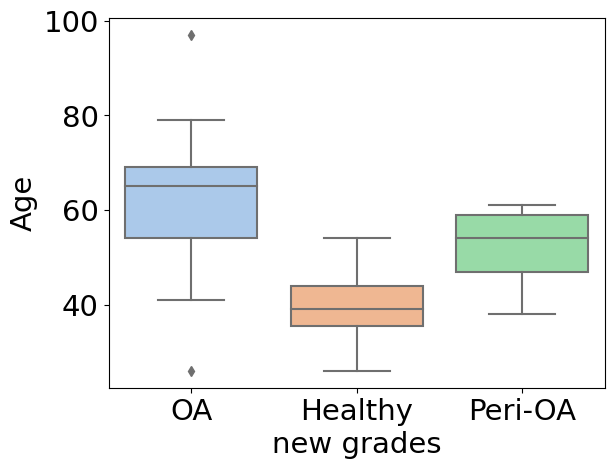

In [33]:
sns.boxplot(data=stat_df, x='new grades', y='Age', palette='pastel')
# plt.title('Age Distribution Across Health Categories')
plt.show()

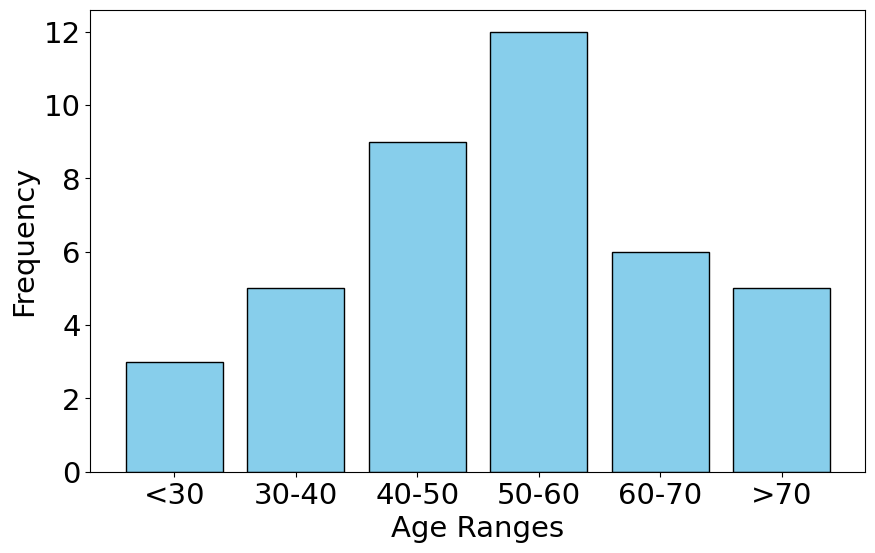

In [35]:
# Create a histogram of ages
age_distribution = []
pre = 0
for t in [30, 40, 50, 60, 70]:
    cur = np.sum(stat_df['Age']<t)
    age_distribution.append(cur-pre)
    pre = cur
age_distribution.append(np.sum(stat_df['Age']>70))
bin_labels = ['<30', '30-40', '40-50', '50-60', '60-70', '>70']
positions = range(len(age_distribution))

# Setting seaborn style
# sns.set(style="whitegrid")

# Same plotting code as the matplotlib example
plt.figure(figsize=(10, 6))
plt.bar(positions, age_distribution, color='skyblue', edgecolor='black')
plt.xticks(positions, bin_labels)

# plt.title('Histogram of Ages')
plt.xlabel('Age Ranges')
plt.ylabel('Frequency')
plt.savefig('./figures/age_histogram.jpg', dpi=300)
plt.show()


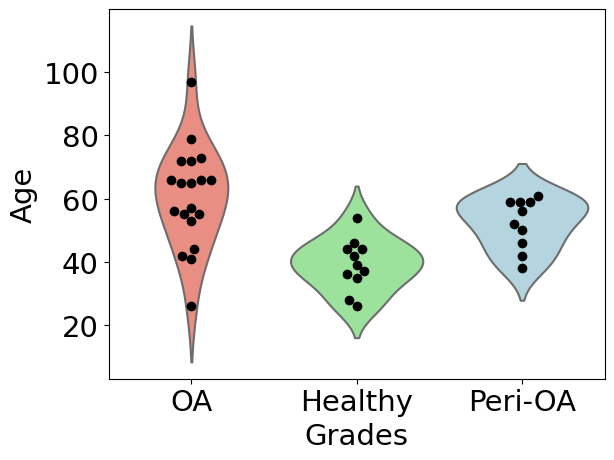

In [36]:
# Create a swarm plot
# Define a color palette
palette = {
    'Healthy': 'lightgreen',
    'Peri-OA': 'lightblue',
    'OA': 'salmon'
}

sns.swarmplot(data=stat_df, x='new grades', y='Age', size=7, color='black')
sns.violinplot(data=stat_df, x='new grades', y='Age', palette=palette, inner=None, edgecolor='gray')
# plt.title('Detailed Distribution of Age and Health Category')
plt.xlabel('Grades')
plt.savefig('./figures/age_vs_new_grades.jpg', dpi=300)
plt.show()

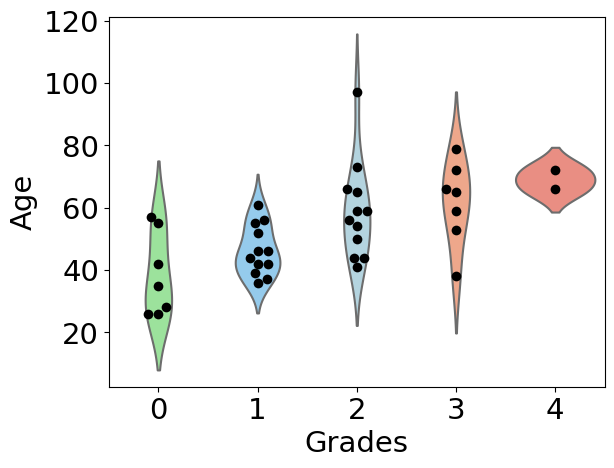

In [37]:
# Create a swarm plot
# Define a color palette
palette = {
    0: '#90EE90',
    1: '#87CEFA',
    2: '#ADD8E6',
    3: '#FFA07A',
    4: 'salmon',
}

sns.swarmplot(data=stat_df, x='old grades', y='Age', size=7, color='black')
sns.violinplot(data=stat_df, x='old grades', y='Age', palette=palette, inner=None, edgecolor='gray')
# plt.title('Detailed Distribution of Age and Health Category')
plt.xlabel('Grades')
plt.savefig('age_vs_old_grades.jpg', dpi=300)
plt.show()

In [38]:
# Count available ids for each modality
with open(os.path.join(processed_data_path, 'static_data.pkl'), 'rb') as file:
    static_data = pickle.load(file)
static_hid = set(list(static_data.keys()))
with open(os.path.join(processed_data_path, 'kinematic_data.pkl'), 'rb') as file:
    kinematic_data = pickle.load(file)
kinematic_hid = set(list(kinematic_data.keys()))

image_hid = set()
for hid in id_list:
    image_list = glob.glob(os.path.join(root_path, f"Data/{hid}/BonyGeometry/DICOMs/CT*/*.IMA"))
    if len(image_list) > 0:
        image_hid.add(hid)



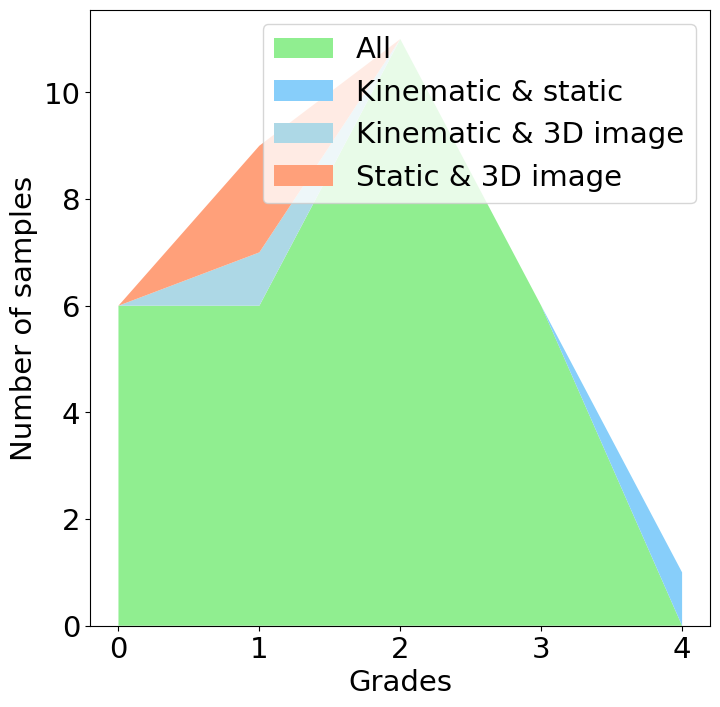

In [40]:
# For the old 5-class scheme
overlap_ks = kinematic_hid & static_hid - image_hid
overlap_ki = kinematic_hid & image_hid - static_hid
overlap_si = static_hid & image_hid - kinematic_hid
overlap_ksi = kinematic_hid & static_hid & image_hid

x = np.arange(5)
y_ksi = np.bincount([grades['old'][hid] for hid in list(overlap_ksi)], minlength=5)
y_ks = np.bincount([grades['old'][hid] for hid in list(overlap_ks)], minlength=5)
y_ki = np.bincount([grades['old'][hid] for hid in list(overlap_ki)], minlength=5)
y_si = np.bincount([grades['old'][hid] for hid in list(overlap_si)], minlength=5)

fig, ax = plt.subplots(figsize=(8, 8))
ax.stackplot(x, y_ksi, y_ks, y_ki, y_si, 
             labels=['All', 'Kinematic & static', 'Kinematic & 3D image', 'Static & 3D image'], 
             colors=['#90EE90','#87CEFA','#ADD8E6','#FFA07A'])
ax.legend(loc='upper right')

plt.xticks(x, np.arange(5))
plt.xlabel('Grades')
plt.ylabel('Number of samples')
plt.savefig('./figures/samples_vs_modality_old.jpg', dpi=300)

plt.show()


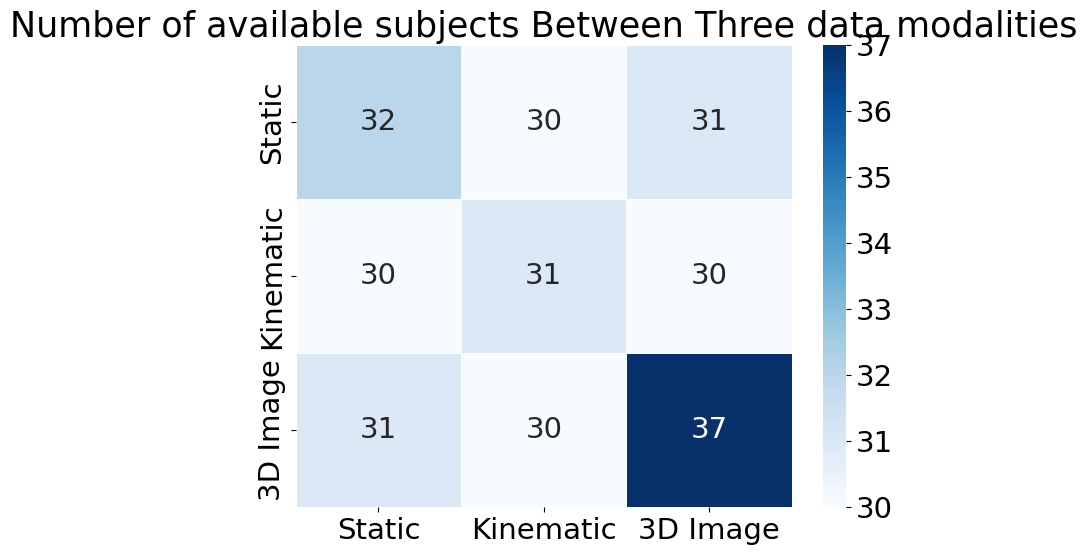

In [41]:
# Calculate intersections under the new scheme

overlap_ks = kinematic_hid & static_hid
overlap_ki = kinematic_hid & image_hid
overlap_si = static_hid & image_hid
overlap_ksi = kinematic_hid & static_hid & image_hid

# Create a DataFrame to represent the overlaps
overlap_data = pd.DataFrame({
    'Static': [len(static_hid), len(overlap_ks), len(overlap_si)],
    'Kinematic': [len(overlap_ks), len(kinematic_hid), len(overlap_ki)],
    '3D Image': [len(overlap_si), len(overlap_ki), len(image_hid)]
}, index=['Static', 'Kinematic', '3D Image'])


plt.figure(figsize=(8, 6))
sns.heatmap(overlap_data, annot=True, fmt="d", cmap="Blues", linewidths=.5)
plt.title('Number of available subjects Between Three data modalities')
plt.show()


#### Count Class sizes

In [42]:
combs = ['static', 'kinematic', 'image', 'kinematic+static', 'image+static', 'image+kinematic', 'all']
for i, hid_list in enumerate([list(static_hid), 
                list(kinematic_hid),
                list(image_hid),
                list(overlap_ks),
                list(overlap_si),
                list(overlap_ki),
                list(overlap_ksi)]):
    print(combs[i])
    print(f'#samples: {len(hid_list)}')
    old_count = collections.Counter([grades['old'][hid] for hid in hid_list])
    new_count = collections.Counter([grades['group'][hid] for hid in hid_list])
    print(f'class size (old grading): {[old_count.get(i, 0) for i in range(5)]}')
    print(f'class size (new grading): {[new_count.get(i, 0) for i in range(3)]}')
    print('\n')

static
#samples: 32
class size (old grading): [6, 8, 11, 6, 1]
class size (new grading): [7, 9, 16]


kinematic
#samples: 31
class size (old grading): [6, 7, 11, 6, 1]
class size (new grading): [6, 9, 16]


image
#samples: 37
class size (old grading): [7, 12, 12, 6, 0]
class size (new grading): [11, 10, 16]


kinematic+static
#samples: 30
class size (old grading): [6, 6, 11, 6, 1]
class size (new grading): [6, 8, 16]


image+static
#samples: 31
class size (old grading): [6, 8, 11, 6, 0]
class size (new grading): [7, 9, 15]


image+kinematic
#samples: 30
class size (old grading): [6, 7, 11, 6, 0]
class size (new grading): [6, 9, 15]


all
#samples: 29
class size (old grading): [6, 6, 11, 6, 0]
class size (new grading): [6, 8, 15]




#### Visualize kinematic data
* Calculated from motion and rigid body data 
* Processing script: kinematic_multiprocessing.py (Edited on 11/2024 by Daniel Gordon)
* subject H7, H8, H16, J2, J4, J8, J9 do not have kinematic data

In [43]:
with open(os.path.join(processed_data_path, 'kinematic_data.pkl'), 'rb') as file:
    kinematic_data = pickle.load(file)
with open(os.path.join(processed_data_path, 'kinematic_raw.pkl'), 'rb') as file:
    kinematic_raw = pickle.load(file)
    
cycles = collections.defaultdict(dict)
all_cycle_sheets = pd.read_excel(os.path.join(root_path, f'Supplements/Kinematic Cycles.xlsx'), sheet_name=None)
for hid in kinematic_raw:
    try:
        cycle_df = all_cycle_sheets[hid]
        for _, row in cycle_df.iterrows():
            gesture = row.iloc[0]
            cur_cycles = []
            for i, value in enumerate(row[1:]):  # skipping index
                if not pd.isna(value):
                    start_idx, end_idx = value.split(':')
                    cur_cycles.append([int(start_idx.strip()), int(end_idx.strip())])
            if cur_cycles:
                cycles[hid][gesture] = cur_cycles
    except:
        print(f'Can not find cycle info for {hid}')

In [44]:
plt.rcParams["axes.grid"] = False 
plt.rcParams['font.size'] = 21 


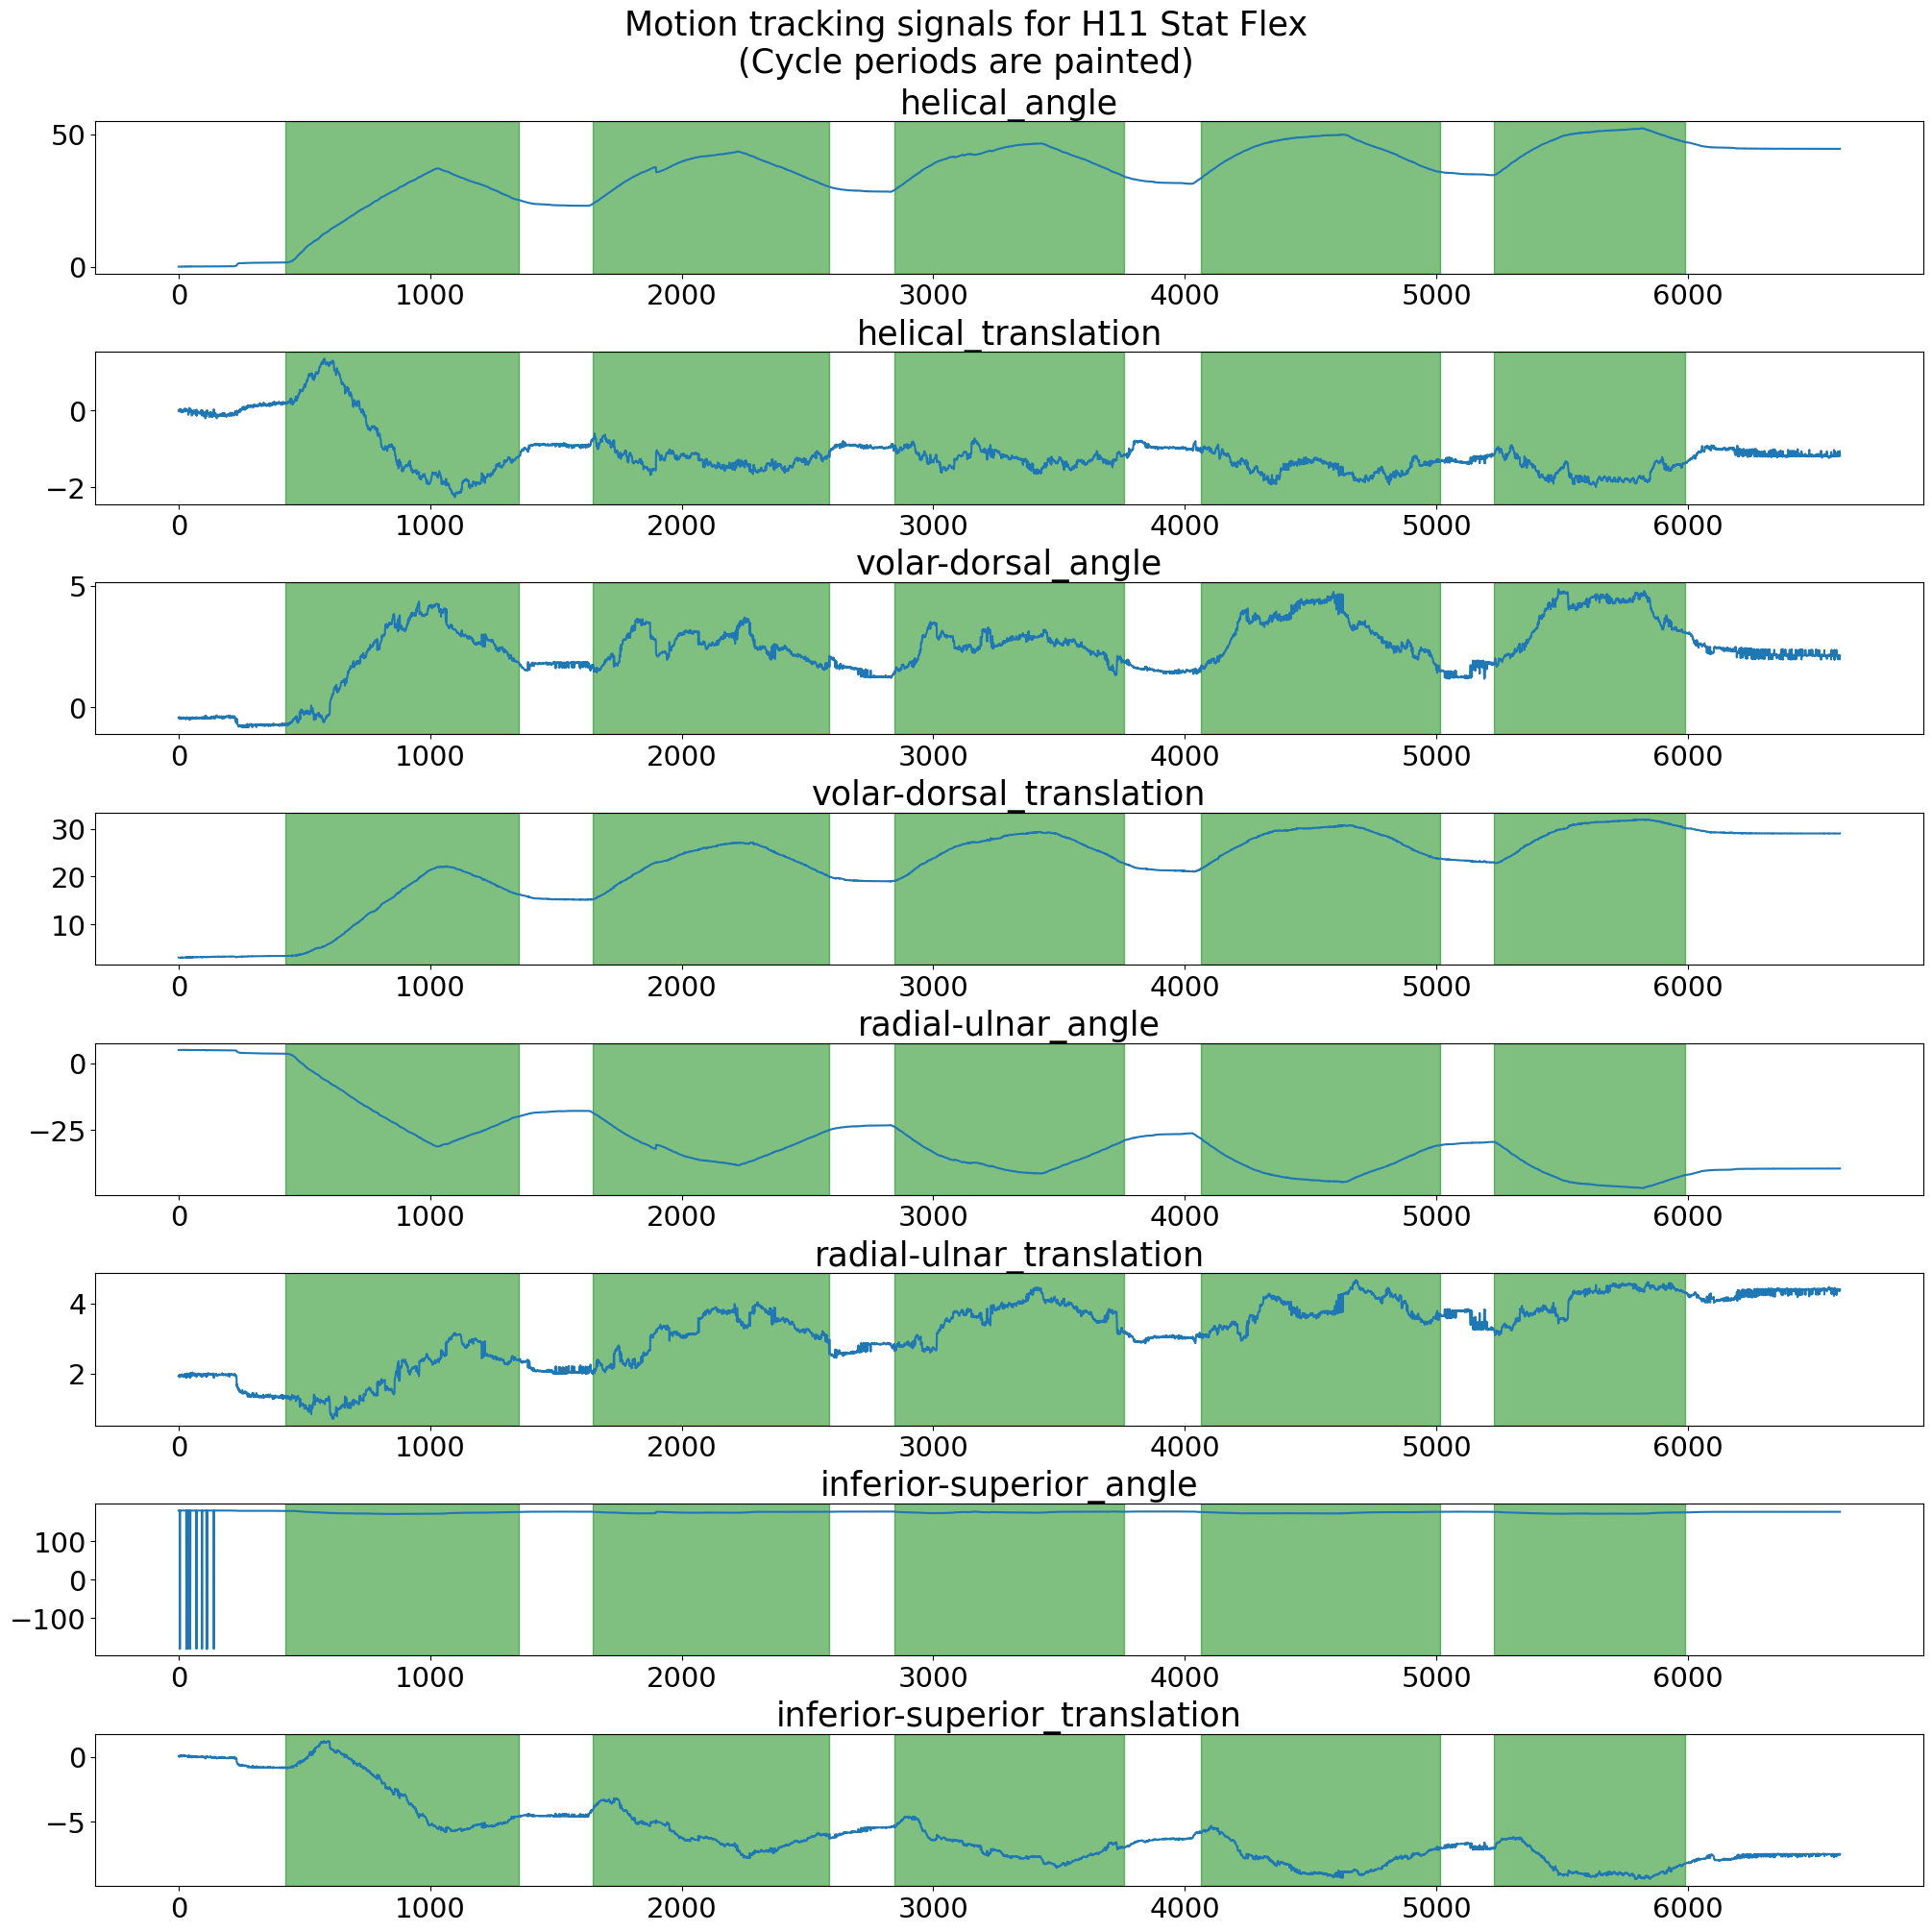

In [45]:
# Visualize cycle data 
hid = 'H11'
gesture = 'Stat Flex'

kinematic_channels = ['helical_angle',
             'helical_translation',
             'volar-dorsal_angle',
             'volar-dorsal_translation',
             'radial-ulnar_angle',
             'radial-ulnar_translation',
             'inferior-superior_angle',
             'inferior-superior_translation']
downsample_rate = 10
fig, axs = plt.subplots(8, 1, 
                        figsize=(20, 20),
                        constrained_layout=True)
for i in range(8):
    axs[i].plot(kinematic_raw[hid][gesture][::downsample_rate, i])
    axs[i].set_title(kinematic_channels[i])
    for start_idx, end_idx in cycles[hid][gesture]:
        axs[i].axvspan(start_idx//downsample_rate, end_idx//downsample_rate, color='g', alpha=0.5, label='cycles')
fig.suptitle(f'Motion tracking signals for {hid} {gesture}\n(Cycle periods are painted)')    
plt.show()
fig.savefig('./figures/time_series.jpg', dpi=600)

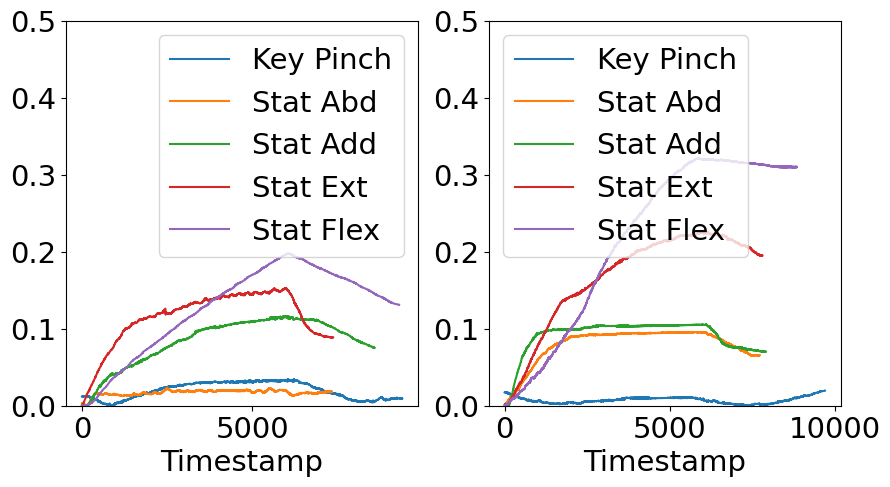

In [46]:
# Visualize processed samples 
# Class: 'H11': 0; 'H10': 1
hid = ['H11', 'H10']
fig, axs = plt.subplots(1, 2,
                        figsize=(10, 5))

for i, hid in enumerate(['H11', 'H10']):
    for gesture in gesture_list:
        x = kinematic_data[hid][gesture][0][:, 0]
        z = (x-min(x))/180
        axs[i].plot(z, label=gesture)
        axs[i].set_xlabel('Timestamp')
        axs[i].set_ylim([0,0.5])
        axs[i].legend()
fig.savefig('./figures/kinematic_example.jpg',dpi=300, bbox_inches='tight')

#### Image data

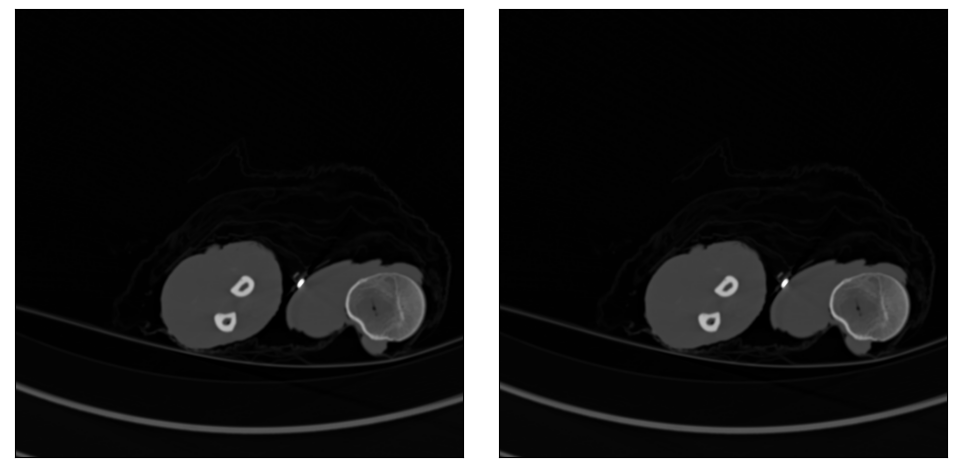

<Figure size 640x480 with 0 Axes>

In [47]:
# Visualize data
hid = 'H11'
image_list = glob.glob(f"/project/ahoover/mhealth/zeyut/tmc/TMC AI Files/Data/{hid}/BonyGeometry/DICOMs/CT/*.IMA")
mask_list = imread(os.path.join(root_path, f"CT Labelling/{hid} Labels.tif"))

cols = 2
fig, axs = plt.subplots(1, cols,
                        figsize=(10, 20))
for c in range(cols):
    img_idx = 300 + cols
    image = imageio.v2.imread(image_list[img_idx])
    mask = (mask_list[img_idx]!=0).astype(int)
    normalized = cv2.normalize(
                image, None, 
                alpha=0, beta=255, 
                norm_type=cv2.NORM_MINMAX).astype('uint8')
    color = np.zeros((512,512,3), dtype='uint8')
    color[:,:,0] = normalized
    color[:,:,1] = normalized
    color[:,:,2] = normalized
    axs[c].imshow(color, cmap='gray')
    # axs[r, c].imshow(mask, cmap='gray')
    axs[c].axes.get_xaxis().set_visible(False)
    axs[c].axes.get_yaxis().set_visible(False)

plt.tight_layout()
plt.show()
plt.tight_layout() 

fig.savefig('./figures/CT_images.jpg', dpi=300, bbox_inches='tight')